In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
from collections import Counter

import data_splitter as ds
import data_loader as dl
import feature_extraction as fex
import run_model as rm
import eval_model as ev

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
KERASTUNER_TUNER_ID="chief"
KERASTUNER_ORACLE_IP="127.0.0.1"
KERASTUNER_ORACLE_PORT="8000"

In [6]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [7]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [8]:
cv_train_by_class = splitter.get_cv_train_img_by_class(cv_img)

--Fold:  0
----Total image_id in training set with class 0:  27450
----Total image_id in training set with class 1:  581
--Fold:  1
----Total image_id in training set with class 0:  27440
----Total image_id in training set with class 1:  576
--Fold:  2
----Total image_id in training set with class 0:  27354
----Total image_id in training set with class 1:  583
--Fold:  3
----Total image_id in training set with class 0:  27440
----Total image_id in training set with class 1:  585
--Fold:  4
----Total image_id in training set with class 0:  27428
----Total image_id in training set with class 1:  575


In [9]:
metadata = pd.read_csv('train.csv')

train_img_ids = cv_img[0]['train']
val_img_ids = cv_img[0]['validate']

## Test on very small data whether the model can learn (overfitting)

### Not controling for class ratio at batch level

In [ ]:
IMG_SIZE = (256, 256, 1)

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

In [ ]:
model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model_layers.summary()

In [12]:
BATCH_SIZE = 8
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [28]:
X_train, y_train = train_gen[0]
print(X_train.shape, y_train.shape)
print(Counter(y_train))
print(y_train)

(8, 256, 256, 3) (8,)
Counter({0: 7, 1: 1})
[0 0 0 1 0 0 0 0]


In [33]:
X_val, y_val = val_gen[4]
print(X_val.shape, y_val.shape)
print(Counter(y_val))
print(y_val)

(8, 256, 256, 3) (8,)
Counter({0: 7, 1: 1})
[0 0 1 0 0 0 0 0]


In [37]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=False,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate=0.000001),
    metrics=METRICS,
    checkpoint_path='models/inception_imagenet_checkpoint/cnn_imagenet_test'
)

Checkpoint path:  models/inception_imagenet_checkpoint/cnn_imagenet_test
---Checkpoint folder already exists
Creating a new model...


In [38]:
EPOCH = 100
history = model.fit(
    X_train, y_train,
    epochs=EPOCH,
    #callbacks=callbacks,
    #validation_data=val_generator,
    #use_multiprocessing = use_multiprocessing,
    #workers = workers,
    validation_data=(X_val, y_val),
    verbose = 1
    )

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4948 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4925 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7

Epoch 20/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4950 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 21/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4956 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 22/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 

Epoch 39/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4953 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 40/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4955 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 41/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 

Epoch 58/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4952 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 59/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4951 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 60/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 

Epoch 77/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4951 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 78/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4951 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 79/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 

Epoch 96/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4951 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 97/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 7.0000 - fn: 1.0000 - accuracy: 0.8750 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.1250 - val_loss: 0.4951 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7.0000 - val_fn: 1.0000 - val_accuracy: 0.8750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0653
Epoch 98/100
1/1 [==============================] - 2s 2s/step - loss: 0.3768 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 

### Controling for class ratio 1:1 at batch level

In [22]:
train_meta = metadata[metadata.patient_id.isin(splitter.trainset.keys())]

cancer_sample = train_meta[train_meta.cancer==1].sample(6)
cancer_img_id = cancer_sample.image_id.unique()
print(cancer_img_id)
cancer_sample

[ 883863733 1416534699  976434791 1366895593  880971379  546226529]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
19023,2,30094,883863733,R,CC,55.0,1,1,0,NaN,0,NaN,48,False
38423,2,51276,1416534699,L,CC,54.0,1,1,0,NaN,0,NaN,21,False
52188,1,7196,976434791,R,CC,61.0,1,1,0,0.0,0,D,49,False
43454,1,56813,1366895593,L,MLO,53.0,1,1,0,0.0,0,C,49,False
11090,1,21880,880971379,R,MLO,63.0,1,1,1,0.0,0,B,170,False
31831,1,44121,546226529,R,CC,65.0,1,1,0,0.0,0,C,49,False


In [23]:
no_cancer_sample = train_meta[train_meta.cancer==0].sample(6)
no_cancer_img_id = no_cancer_sample.image_id.unique()
print(no_cancer_img_id)
no_cancer_sample

[ 244433205  835545786 1524382603 1406437857 1898048931  651051216]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
25922,1,37722,244433205,R,MLO,72.0,0,0,0,2.0,0,B,49,False
3207,2,13397,835545786,L,CC,60.0,0,0,0,NaN,0,NaN,21,False
26497,1,38342,1524382603,R,MLO,66.0,0,0,0,1.0,0,C,49,False
27130,1,38964,1406437857,R,MLO,72.0,0,1,0,0.0,0,B,49,True
11386,1,22218,1898048931,R,CC,59.0,0,0,0,1.0,0,B,49,False
38005,2,50815,651051216,R,CC,59.0,0,0,0,NaN,0,NaN,29,False


In [29]:
train_img_ids = [*cancer_img_id[:3], *no_cancer_img_id[:3]]
val_img_ids = [*cancer_img_id[3:], *no_cancer_img_id[3:]]
print(train_img_ids, val_img_ids)

[883863733, 1416534699, 976434791, 244433205, 835545786, 1524382603] [1366895593, 880971379, 546226529, 1406437857, 1898048931, 651051216]


In [30]:
BATCH_SIZE = 6
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [31]:
print(len(train_gen), len(val_gen))

1 1


In [32]:
X_train, y_train = train_gen[0]
print(X_train.shape, y_train.shape)
print(Counter(y_train))
print(y_train)

(6, 256, 256, 3) (6,)
Counter({0: 3, 1: 3})
[0 0 0 1 1 1]


In [33]:
X_val, y_val = val_gen[0]
print(X_val.shape, y_val.shape)
print(Counter(y_val))
print(y_val)

(6, 256, 256, 3) (6,)
Counter({0: 3, 1: 3})
[0 1 1 1 0 0]


In [36]:
IMG_SIZE = (256, 256, 1)

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid')
])


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=False,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/cnn_imagenet_test'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/cnn_imagenet_test
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [37]:
EPOCH = 100
history = model.fit(
    X_train, y_train,
    epochs=EPOCH,
    validation_data=(X_val, y_val),
    verbose = 1
    )

Epoch 1/100


/home/irinb/.local/lib/python3.9/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 8s 8s/step - loss: 0.7915 - tp: 3.0000 - fp: 3.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - auc: 0.1111 - prc: 0.3242 - val_loss: 0.7569 - val_tp: 3.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.0000e+00 - val_prc: 0.3069
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.7808 - tp: 3.0000 - fp: 3.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - auc: 0.1111 - prc: 0.3242 - val_loss: 0.7563 - val_tp: 3.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.0000e+00 - val_prc: 0.3069
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.7703 - tp: 3.0000 - fp: 3.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5000 - precis

Epoch 21/100
1/1 [==============================] - 1s 1s/step - loss: 0.6156 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7598 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.3333 - val_precision: 0.4000 - val_recall: 0.6667 - val_auc: 0.2222 - val_prc: 0.3556
Epoch 22/100
1/1 [==============================] - 1s 1s/step - loss: 0.6082 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7597 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.3333 - val_precision: 0.4000 - val_recall: 0.6667 - val_auc: 0.2222 - val_prc: 0.3556
Epoch 23/100
1/1 [==============================] - 1s 1s/step - loss: 0.6009 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precisi

Epoch 41/100
1/1 [==============================] - 1s 1s/step - loss: 0.4849 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7575 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.3333 - val_precision: 0.4000 - val_recall: 0.6667 - val_auc: 0.3333 - val_prc: 0.3948
Epoch 42/100
1/1 [==============================] - 1s 1s/step - loss: 0.4793 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7575 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.3333 - val_precision: 0.4000 - val_recall: 0.6667 - val_auc: 0.3333 - val_prc: 0.3948
Epoch 43/100
1/1 [==============================] - 1s 1s/step - loss: 0.4737 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precisi

Epoch 61/100
1/1 [==============================] - 1s 1s/step - loss: 0.3863 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7579 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.3333 - val_precision: 0.4000 - val_recall: 0.6667 - val_auc: 0.6667 - val_prc: 0.8177
Epoch 62/100
1/1 [==============================] - 1s 1s/step - loss: 0.3821 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7580 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.3333 - val_precision: 0.4000 - val_recall: 0.6667 - val_auc: 0.6111 - val_prc: 0.7426
Epoch 63/100
1/1 [==============================] - 1s 1s/step - loss: 0.3780 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precisi

Epoch 81/100
1/1 [==============================] - 1s 1s/step - loss: 0.3125 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7595 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.3333 - val_precision: 0.4000 - val_recall: 0.6667 - val_auc: 0.6667 - val_prc: 0.8177
Epoch 82/100
1/1 [==============================] - 1s 1s/step - loss: 0.3093 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.7596 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.3333 - val_precision: 0.4000 - val_recall: 0.6667 - val_auc: 0.6667 - val_prc: 0.8177
Epoch 83/100
1/1 [==============================] - 1s 1s/step - loss: 0.3062 - tp: 3.0000 - fp: 0.0000e+00 - tn: 3.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precisi

In [39]:
cancer_sample = train_meta[train_meta.cancer==1].sample(2)
cancer_img_id = cancer_sample.image_id.unique()
print(cancer_img_id)

no_cancer_sample = train_meta[train_meta.cancer==0].sample(28)
no_cancer_img_id = no_cancer_sample.image_id.unique()
print(no_cancer_img_id)

test_img_ids = [*cancer_img_id, *no_cancer_img_id]

BATCH_SIZE = 28
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

test_gen = dl.DataGenerator(
        test_img_ids,

        labels = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

print(len(test_gen))

[713409726 207616196]
[1053337709  903019405  615943180  552717148  307990593 1688251890
  432805296 1918054170 1881447117  115875739 2144077552 1040150884
  304866081  590974164 2041031241  973166128 1036301098 1514842984
  445011971  757972543 1056569204  841536964  912650380  772837332
 1616039919  266166386 1588508806  556939261]
1


In [ ]:
model.predict(test_gen)

2023-04-05 14:37:37.890180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


# Using full training set and control for class ratio at batch level 

## Image Resolution 256 x 256 with ImageNet weights

In [59]:
IMG_SIZE = (256, 256, 1)

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_470 (Conv2D)            (None, 127, 127, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_470 (Batch  (None, 127, 127, 32  96         ['conv2d_470[0][0]']             
 Normalization)                 )                                                      

 conv2d_481 (Conv2D)            (None, 29, 29, 32)   6144        ['average_pooling2d_45[0][0]']   
                                                                                                  
 batch_normalization_475 (Batch  (None, 29, 29, 64)  192         ['conv2d_475[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_477 (Batch  (None, 29, 29, 64)  192         ['conv2d_477[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_480 (Batch  (None, 29, 29, 96)  288         ['conv2d_480[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_492 (Conv2D)            (None, 29, 29, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_492 (Batch  (None, 29, 29, 64)  192         ['conv2d_492[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_492 (Activation)    (None, 29, 29, 64)   0           ['batch_normalization_492[0][0]']
                                                                                                  
 conv2d_490 (Conv2D)            (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_49

                                                                                                  
 activation_499 (Activation)    (None, 14, 14, 96)   0           ['batch_normalization_499[0][0]']
                                                                                                  
 max_pooling2d_22 (MaxPooling2D  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_496[0][0]',         
                                                                  'activation_499[0][0]',         
                                                                  'max_pooling2d_22[0][0]']       
                                                                                                  
 conv2d_50

 mixed4 (Concatenate)           (None, 14, 14, 768)  0           ['activation_500[0][0]',         
                                                                  'activation_503[0][0]',         
                                                                  'activation_508[0][0]',         
                                                                  'activation_509[0][0]']         
                                                                                                  
 conv2d_514 (Conv2D)            (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_514 (Batch  (None, 14, 14, 160)  480        ['conv2d_514[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_524 (Conv2D)            (None, 14, 14, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_524 (Batch  (None, 14, 14, 160)  480        ['conv2d_524[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_524 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_524[0][0]']
                                                                                                  
 conv2d_525 (Conv2D)            (None, 14, 14, 160)  179200      ['activation_524[0][0]']         
                                                                                                  
 batch_normalization_525 (Batch  (None, 14, 14, 160)  480        ['conv2d_525[0][0]']             
 Normaliza

 activation_534 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_534[0][0]']
                                                                                                  
 conv2d_535 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_534[0][0]']         
                                                                                                  
 batch_normalization_535 (Batch  (None, 14, 14, 192)  576        ['conv2d_535[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_535 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_535[0][0]']
                                                                                                  
 conv2d_531 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_543 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_543[0][0]']
                                                                                                  
 conv2d_540 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_544 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_543[0][0]']         
                                                                                                  
 batch_normalization_540 (Batch  (None, 14, 14, 192)  576        ['conv2d_540[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_554 (Conv2D)            (None, 6, 6, 192)    245760      ['average_pooling2d_52[0][0]']   
                                                                                                  
 batch_normalization_546 (Batch  (None, 6, 6, 320)   960         ['conv2d_546[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_548 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_548[0][0]']
                                                                                                  
 activation_549 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_549[0][0]']
          

                                                                                                  
 activation_557 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_557[0][0]']
                                                                                                  
 activation_558 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_558[0][0]']
                                                                                                  
 activation_561 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_561[0][0]']
                                                                                                  
 activation_562 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_562[0][0]']
                                                                                                  
 batch_normalization_563 (Batch  (None, 6, 6, 192)   576         ['conv2d_563[0][0]']             
 Normaliza

In [60]:
train_img_ids = cv_img[0]['train']
val_img_ids = cv_img[0]['validate']

In [47]:
BATCH_SIZE = 4*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        train_img_by_class = cv_train_by_class[0],
        train_class_ratio = (0.5, 0.5),
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,

        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [48]:
print(len(train_gen), len(val_gen))
X, y = train_gen[0]
print(X.shape, y.shape)
print(Counter(y))

428 54
(128, 256, 256, 3) (128,)
Counter({0: 64, 1: 64})


In [49]:
X, y = val_gen[0]
print(X.shape, y.shape)
print(Counter(y))

(128, 256, 256, 3) (128,)
Counter({0: 124, 1: 4})


In [15]:
inception.output.shape[-3:]

TensorShape([6, 6, 2048])

## Out of the box

In [61]:
model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model_layers.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [62]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [17]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_classratio_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

2023-04-13 03:55:52.673592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/100


2023-04-13 03:56:25.167330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


428/428 [==============================] - ETA: 0s - loss: 0.6932 - tp: 9600.0000 - fp: 9600.0000 - tn: 17792.0000 - fn: 17792.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3505 - auc: 0.5000 - prc: 0.5000

2023-04-13 04:01:06.813133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.81134, saving model to models/inception_imagenet_checkpoint/imagenet_classratio_adam-lr-default-01-prc0.02-tp91.0-loss0.81.hdf5
428/428 [==============================] - 374s 793ms/step - loss: 0.6932 - tp: 9600.0000 - fp: 9600.0000 - tn: 17792.0000 - fn: 17792.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3505 - auc: 0.5000 - prc: 0.5000 - val_loss: 0.8113 - val_tp: 91.0000 - val_fp: 4742.0000 - val_tn: 2029.0000 - val_fn: 50.0000 - val_accuracy: 0.3067 - val_precision: 0.0188 - val_recall: 0.6454 - val_auc: 0.4639 - val_prc: 0.0184
Epoch 2/100
428/428 [==============================] - ETA: 0s - loss: 0.6931 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27392.0000 - fn: 27392.0000 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.5000
Epoch 2: val_loss improved from 0.81134 to 0.81046, saving model to models/inception_imagenet_checkpoint/imagenet_classratio_adam-lr-default-02-prc0.02-tp94.0-loss0.81.h

Process Keras_worker_ForkPoolWorker-2479:
Process Keras_worker_ForkPoolWorker-2474:
Process Keras_worker_ForkPoolWorker-2476:
Process Keras_worker_ForkPoolWorker-2477:
Process Keras_worker_ForkPoolWorker-2480:
Process Keras_worker_ForkPoolWorker-2458:
Process Keras_worker_ForkPoolWorker-2464:
Process Keras_worker_ForkPoolWorker-2473:
Process Keras_worker_ForkPoolWorker-2457:
Process Keras_worker_ForkPoolWorker-2459:
Process Keras_worker_ForkPoolWorker-2470:
Process Keras_worker_ForkPoolWorker-2463:
Process Keras_worker_ForkPoolWorker-2460:
Process Keras_worker_ForkPoolWorker-2478:
Process Keras_worker_ForkPoolWorker-2472:
Process Keras_worker_ForkPoolWorker-2468:
Process Keras_worker_ForkPoolWorker-2466:
Process Keras_worker_ForkPoolWorker-2442:
Process Keras_worker_ForkPoolWorker-2461:
Process Keras_worker_ForkPoolWorker-2462:
Process Keras_worker_ForkPoolWorker-2469:
Process Keras_worker_ForkPoolWorker-2450:
Process Keras_worker_ForkPoolWorker-2456:
Process Keras_worker_ForkPoolWorke

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108,

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()


  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 9

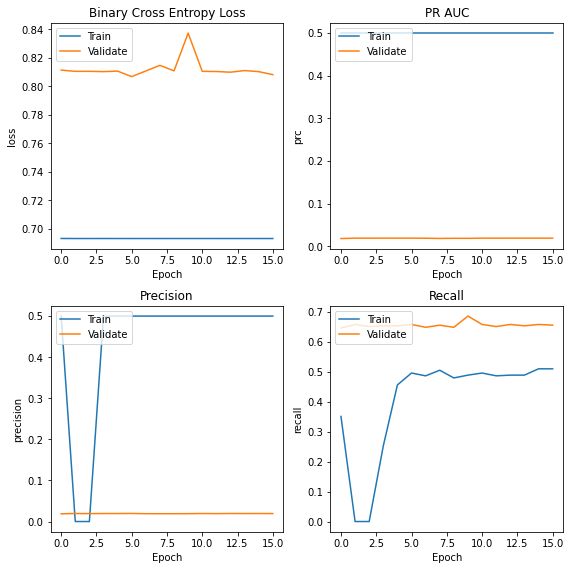

In [19]:
ev.plot_history(history)

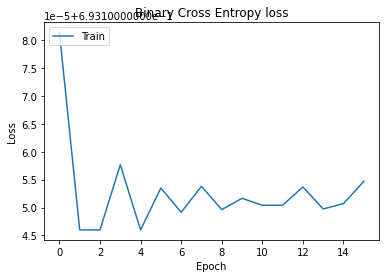

In [20]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

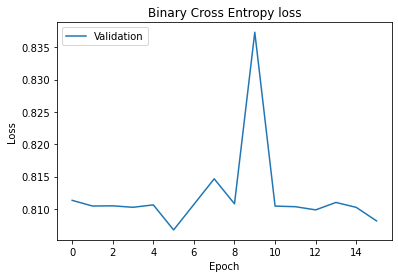

In [21]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Increase learning rate and reduce batch size from 4 x 64 to 2 x 64

In [51]:
BATCH_SIZE = 2*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        train_img_by_class = cv_train_by_class[0],
        train_class_ratio = (0.5, 0.5),
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,

        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [52]:
print(len(train_gen), len(val_gen))

X, y = train_gen[0]
print(X.shape, y.shape)
print(Counter(y))

X, y = val_gen[0]
print(X.shape, y.shape)
print(Counter(y))

857 108
(64, 256, 256, 3) (64,)
Counter({1: 32, 0: 32})
(64, 256, 256, 3) (64,)
Counter({0: 64})


In [53]:
LEARNING_RATE = 0.01

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_7 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [54]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_classratio_batch64_adam-lr-1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-13 09:20:04.564283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


857/857 [==============================] - ETA: 0s - loss: 61.5072 - tp: 14671.0000 - fp: 21297.0000 - tn: 12896.0000 - fn: 12896.0000 - accuracy: 0.4464 - precision: 0.4079 - recall: 0.5322 - auc: 0.4367 - prc: 0.4028

2023-04-13 09:25:00.951895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.20992, saving model to models/inception_imagenet_checkpoint/imagenet_256_classratio_batch64_adam-lr-1e-2-01-prc0.02-tp142.0-loss1.21.hdf5
857/857 [==============================] - 361s 400ms/step - loss: 61.5072 - tp: 14671.0000 - fp: 21297.0000 - tn: 12896.0000 - fn: 12896.0000 - accuracy: 0.4464 - precision: 0.4079 - recall: 0.5322 - auc: 0.4367 - prc: 0.4028 - val_loss: 1.2099 - val_tp: 142.0000 - val_fp: 6664.0000 - val_tn: 105.0000 - val_fn: 1.0000 - val_accuracy: 0.0357 - val_precision: 0.0209 - val_recall: 0.9930 - val_auc: 0.5199 - val_prc: 0.0227
Epoch 2/100
857/857 [==============================] - ETA: 0s - loss: 0.6932 - tp: 1408.0000 - fp: 1408.0000 - tn: 26016.0000 - fn: 26016.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.0513 - auc: 0.5000 - prc: 0.5000
Epoch 2: val_loss improved from 1.20992 to 1.20917, saving model to models/inception_imagenet_checkpoint/imagenet_256_classratio_batch64_adam-lr-1e-2-02-prc0.02-tp143.

857/857 [==============================] - ETA: 0s - loss: 0.6937 - tp: 13760.0000 - fp: 13760.0000 - tn: 13664.0000 - fn: 13664.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5018 - auc: 0.5000 - prc: 0.5000
Epoch 23: val_loss did not improve from 1.11698
857/857 [==============================] - 538s 611ms/step - loss: 0.6937 - tp: 13760.0000 - fp: 13760.0000 - tn: 13664.0000 - fn: 13664.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5018 - auc: 0.5000 - prc: 0.5000 - val_loss: 1.2064 - val_tp: 143.0000 - val_fp: 6660.0000 - val_tn: 108.0000 - val_fn: 1.0000 - val_accuracy: 0.0363 - val_precision: 0.0210 - val_recall: 0.9931 - val_auc: 0.5202 - val_prc: 0.0229
>>> Training time:  12038.499764680862


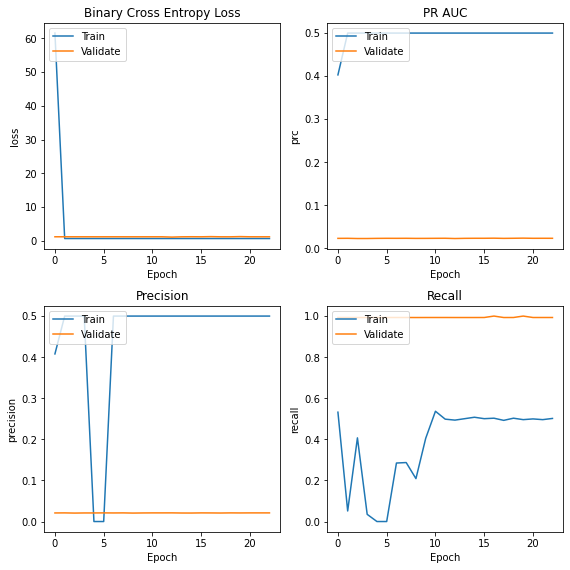

In [55]:
ev.plot_history(history)

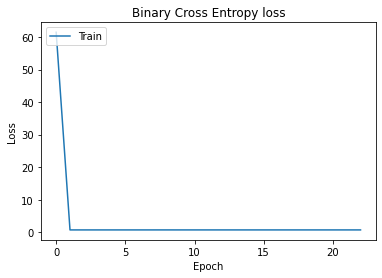

In [56]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

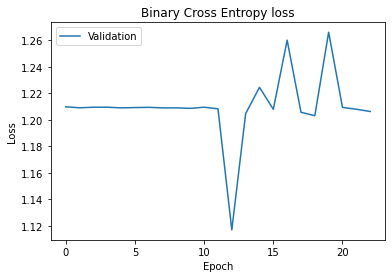

In [57]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Reduce learning rate  to 1e-5 (batch size 4 x 32)

In [63]:
LEARNING_RATE = 1e-5

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_12 (Sequential)  (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_classratio_batch64_adam-lr-1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-13 13:19:12.552993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


857/857 [==============================] - ETA: 0s - loss: 0.6962 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27424.0000 - fn: 27424.0000 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.5000

2023-04-13 13:28:40.181113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.07747, saving model to models/inception_imagenet_checkpoint/imagenet_256_classratio_batch64_adam-lr-1e-5-01-prc0.02-tp134.0-loss1.08.hdf5
857/857 [==============================] - 674s 761ms/step - loss: 0.6962 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27424.0000 - fn: 27424.0000 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.5000 - val_loss: 1.0775 - val_tp: 134.0000 - val_fp: 6388.0000 - val_tn: 383.0000 - val_fn: 7.0000 - val_accuracy: 0.0748 - val_precision: 0.0205 - val_recall: 0.9504 - val_auc: 0.5384 - val_prc: 0.0223
Epoch 2/100
614/857 [====================>.........] - ETA: 2:35 - loss: 0.6931 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 19648.0000 - fn: 19648.0000 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.5000

### Use initial bias and class weights

In [ ]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
initial_bias = np.log([pos/neg])
print(initial_bias)

In [ ]:
initial_bias = tf.keras.initializers.Constant()

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias)
])

model_layers.summary()

In [ ]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

### Adjusting class ratio to 1:4 

In [30]:
BATCH_SIZE = 4*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        train_img_by_class = cv_train_by_class[0],
        train_class_ratio = (0.8, 0.2),
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,

        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [32]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [33]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_classratio_4-1_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-13 06:51:13.687972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


269/269 [==============================] - ETA: 0s - loss: -3210248877768704.0000 - tp: 27438.0000 - fp: 6994.0000 - tn: 6769.0000 - fn: 143.0000 - accuracy: 0.3329 - precision: 0.7969 - recall: 0.9948 - auc: 0.7433 - prc: 0.7965

2023-04-13 06:54:11.403441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 152.21751, saving model to models/inception_imagenet_checkpoint/imagenet_classratio_4-1_adam-lr-default-01-prc0.02-tp143.0-loss152.22.hdf5
269/269 [==============================] - 242s 840ms/step - loss: -3210248877768704.0000 - tp: 27438.0000 - fp: 6994.0000 - tn: 6769.0000 - fn: 143.0000 - accuracy: 0.3329 - precision: 0.7969 - recall: 0.9948 - auc: 0.7433 - prc: 0.7965 - val_loss: 152.2175 - val_tp: 143.0000 - val_fp: 6769.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0207 - val_precision: 0.0207 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0207
Epoch 2/100
269/269 [==============================] - ETA: 0s - loss: -9614898472419328.0000 - tp: 27438.0000 - fp: 6994.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2031 - precision: 0.7969 - recall: 1.0000 - auc: 0.5000 - prc: 0.7969
Epoch 2: val_loss did not improve from 152.21751
269/269 [==============================] - 221s 788ms/step - loss: -961489847241932

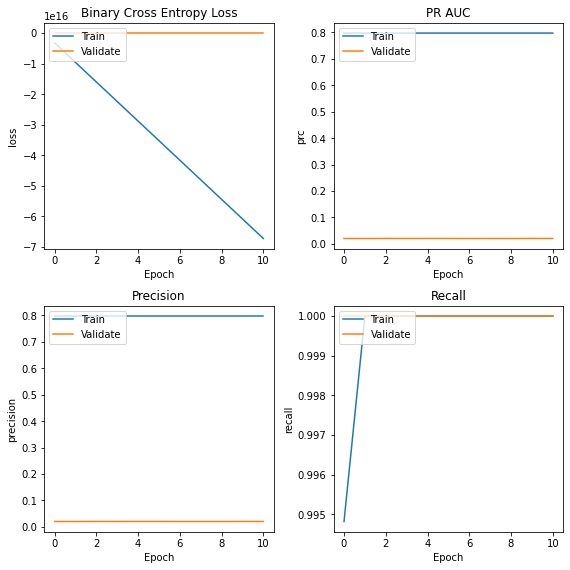

In [34]:
ev.plot_history(history)

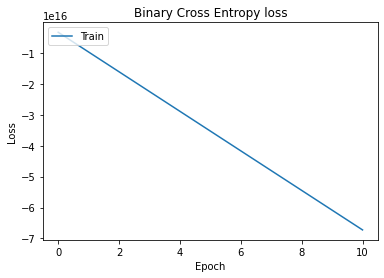

In [35]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

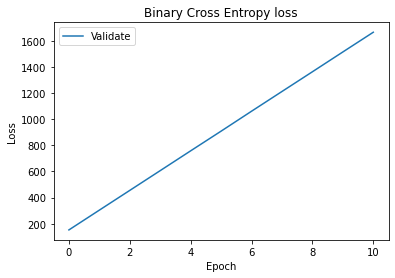

In [36]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validate'], loc='upper left')
plt.show()

### Adjusting class ratio to 1:4 and use initial bias + class weights

In [37]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
initial_bias = np.log([pos/neg])
print(initial_bias)

[-3.83388407]


In [38]:
initial_bias = tf.keras.initializers.Constant()

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias)
])

model_layers.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [39]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [40]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_7 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [41]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_classratio_4-1_bias_weight_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-13 08:06:37.189479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


269/269 [==============================] - ETA: 0s - loss: -3199097532055552.0000 - tp: 27581.0000 - fp: 13763.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.1726 - precision: 0.6671 - recall: 1.0000 - auc: 0.4801 - prc: 0.6580

2023-04-13 08:09:38.042074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 152.38213, saving model to models/inception_imagenet_checkpoint/imagenet_classratio_4-1_bias_weight_adam-lr-default-01-prc0.02-tp144.0-loss152.38.hdf5
269/269 [==============================] - 248s 871ms/step - loss: -3199097532055552.0000 - tp: 27581.0000 - fp: 13763.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.1726 - precision: 0.6671 - recall: 1.0000 - auc: 0.4801 - prc: 0.6580 - val_loss: 152.3821 - val_tp: 144.0000 - val_fp: 6768.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0208 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0208
Epoch 2/100
269/269 [==============================] - ETA: 0s - loss: -9603748737318912.0000 - tp: 27438.0000 - fp: 6994.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.2031 - precision: 0.7969 - recall: 1.0000 - auc: 0.5000 - prc: 0.7969
Epoch 2: val_loss did not improve from 152.38213
269/269 [==============================] - 230s 815ms/step - loss: 

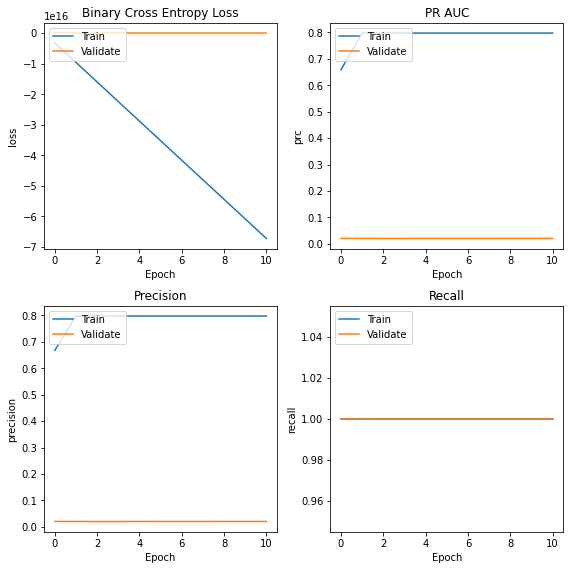

In [42]:
ev.plot_history(history)

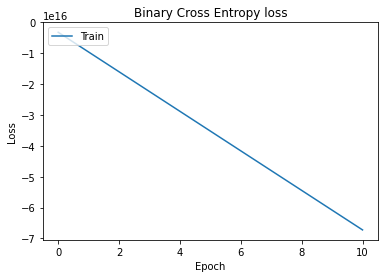

In [43]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

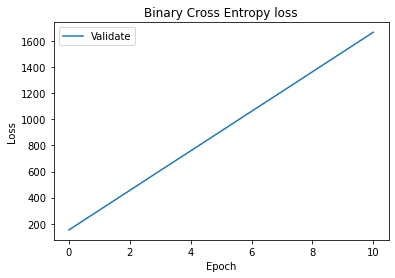

In [44]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validate'], loc='upper left')
plt.show()

## Image Resolution 256 x 256 from scratch

In [24]:
IMG_SIZE = (256, 256, 1)

inception = keras.applications.InceptionV3(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 127, 127, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 127, 127, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

 batch_normalization_193 (Batch  (None, 29, 29, 64)  192         ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_195 (Batch  (None, 29, 29, 64)  192         ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_198 (Batch  (None, 29, 29, 96)  288         ['conv2d_198[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_199 (Batch  (None, 29, 29, 32)  96          ['conv2d_199[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_210 (Batch  (None, 29, 29, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_210 (Activation)    (None, 29, 29, 64)   0           ['batch_normalization_210[0][0]']
                                                                                                  
 conv2d_208 (Conv2D)            (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_211 (Conv2D)            (None, 29, 29, 96)   55296       ['activation_210[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_10[0][0]']       
                                                                                                  
 conv2d_222 (Conv2D)            (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_nor

                                                                  'activation_226[0][0]',         
                                                                  'activation_227[0][0]']         
                                                                                                  
 conv2d_232 (Conv2D)            (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_232 (Batch  (None, 14, 14, 160)  480        ['conv2d_232[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_232[0][0]']
                                                                                                  
 conv2d_23

 batch_normalization_242 (Batch  (None, 14, 14, 160)  480        ['conv2d_242[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_242[0][0]']
                                                                                                  
 conv2d_243 (Conv2D)            (None, 14, 14, 160)  179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 14, 14, 160)  480        ['conv2d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_253 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_252[0][0]']         
                                                                                                  
 batch_normalization_253 (Batch  (None, 14, 14, 192)  576        ['conv2d_253[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_253 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_249 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_254 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_253[0][0]']         
          

 activation_261 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_261[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_262 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_258 (Batch  (None, 14, 14, 192)  576        ['conv2d_258[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_262 (Batch  (None, 14, 14, 192)  576        ['conv2d_262[0][0]']             
 Normaliza

 conv2d_272 (Conv2D)            (None, 6, 6, 192)    245760      ['average_pooling2d_25[0][0]']   
                                                                                                  
 batch_normalization_264 (Batch  (None, 6, 6, 320)   960         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_266 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_266[0][0]']
                                                                                                  
 activation_267 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_267[0][0]']
                                                                                                  
 activation_270 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_270[0][0]']
          

                                                                                                  
 activation_276 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_276[0][0]']
                                                                                                  
 activation_279 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_279[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 batch_normalization_281 (Batch  (None, 6, 6, 192)   576         ['conv2d_281[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

### Out of the box

In [25]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True, # set this to True to train all layers
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [26]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/rsna_classratio_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-13 05:37:50.566870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


428/428 [==============================] - ETA: 0s - loss: 0.6940 - tp: 13597.0000 - fp: 18207.0000 - tn: 15955.0000 - fn: 13937.0000 - accuracy: 0.4790 - precision: 0.4275 - recall: 0.4938 - auc: 0.4627 - prc: 0.3940

2023-04-13 05:42:54.522979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.85362, saving model to models/inception_imagenet_checkpoint/rsna_classratio_adam-lr-default-01-prc0.02-tp62.0-loss2.85.hdf5
428/428 [==============================] - 366s 778ms/step - loss: 0.6940 - tp: 13597.0000 - fp: 18207.0000 - tn: 15955.0000 - fn: 13937.0000 - accuracy: 0.4790 - precision: 0.4275 - recall: 0.4938 - auc: 0.4627 - prc: 0.3940 - val_loss: 2.8536 - val_tp: 62.0000 - val_fp: 3168.0000 - val_tn: 3601.0000 - val_fn: 81.0000 - val_accuracy: 0.5299 - val_precision: 0.0192 - val_recall: 0.4336 - val_auc: 0.4675 - val_prc: 0.0186
Epoch 2/100
428/428 [==============================] - ETA: 0s - loss: 0.6932 - tp: 13824.0000 - fp: 13824.0000 - tn: 13568.0000 - fn: 13568.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5047 - auc: 0.5000 - prc: 0.5000
Epoch 2: val_loss did not improve from 2.85362
428/428 [==============================] - 346s 777ms/step - loss: 0.6932 - tp: 13824.0000 - fp: 13824.0000 - tn: 13568.0000 - fn: 1

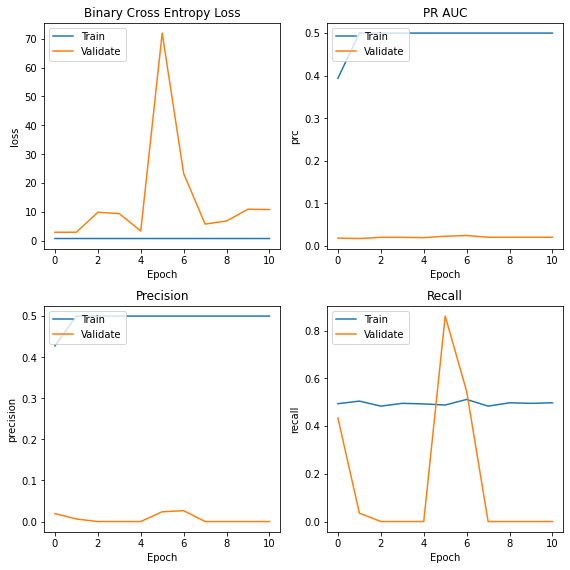

In [27]:
ev.plot_history(history)

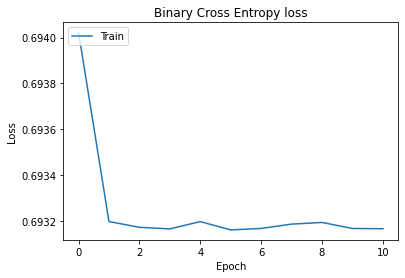

In [28]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

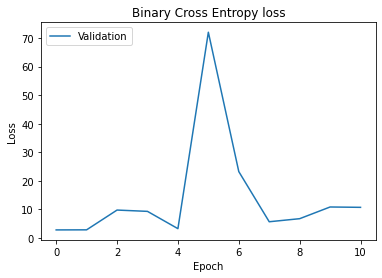

In [29]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

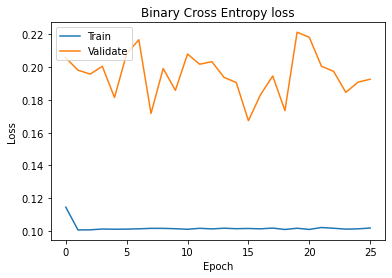

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()